# Fitting multi-position curves from multiple files

This script uses functions and a class object defined in the fit_FCS.py file. **Make sure that the 2 files are saved in the same location !!**

The idea behind class usage is to embed in the class a number of experimental informations (concentrations, laser power, acquisition parameters...), that can be recalled afterwards.

## Table of content
- [Import Libraries and functions](#libraries)
- [Define the input and output folders](#folders)
- [Define the experimental parameters](#exp_param)
- [Define the fitting parameters](#fit_param)
- [Manually select good data](#select)
- [Fit and plot data](#fit)
- [Plot the fitted parameters](#plot)


---

---

## Import Libraries and functions <a class="anchor" id="libraries"></a>



In [7]:
import numpy as np
import pandas as pd
from numpy import loadtxt
from math import *
import os
import linecache
from lmfit import Parameters, minimize


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from fit_FCS import *
from fit_FCS import func1,func2

---
## Define the input and output folders <a class='anchor' id='folders'></a>


- Change the paths to the input folder : **this folder should contain all your folders with your experiments**. Then you need to have your data in one folder per experiment, whose name is the date of the experiment.
- Change the path of the output folder : this is the folder where all results will be stored (graphs, dataframes...)
- You can manually remove unwanted files from the analysis (in this case, uncomment the two lines and change names accordingly)



In [8]:
Folder = '/Users/christine/Documents/Data/DropInOut/FCS/Vincent/' 
OutputFolder = '/Users/christine/Documents/Data/DropInOut/FCS/Vincent/Results/'

Enter the date (which should correspond to the name of the folder where you have your data) 

In [9]:
date = '240112'
InputFolder = Folder+date+'/csv/'

files = os.listdir(InputFolder)
files.remove('.DS_Store')

# Remove files that do not have the expected number of curves or for other reasons
#files.remove('10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv')
#files.remove('40µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv')

print(files)

['10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time15.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time10.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time60.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time75.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time65.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time70.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time55.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time40.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time80.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time50.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time45.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time35.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time20.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time30.csv', '10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time25.csv']


---

## Define the experimental parameters <a class='anchor' id='exp_param'></a>

- Enter the w0 and z0 obtained from the calibration
- Enter the experimental conditions


In [10]:
w0 = 0.337
Z0 = 3.38
V = 0.75636      # excitation volume in um^3

exp_guy = "Vincent"
fluo = 12      # concentration of the fluorescent peptide in nM
cold = 600     # concentration of the unlabeled peptide in uM
rna = 0.5      # concentration of the RNA in mg/mL
PKA = 0        # concentration of the PKA in U
LPP = 0        # concentration of the lambda phosphatase in U
mncl2 = 0      # concentration of MnCl2 in mM
height = 1     # distance of measurement (from the coverslip)

# Enter number of species for the fit - if 2, 1 species fitting will als be performed, fit performanace will be compared.
nb = 2

# Do you want to plot the individual FCS + FIT curves (0=no / 1=yes) ?
plotcorr = 1

# Do you want to print the individual results of the fits (0=no / 1=yes) ?
printres = 0

---

## Define the fitting parameters <a class='anchor' id='fit_param'></a>

Here are defined the initial and bounding values for the different parameters to be fitted. If you want ot fix one of these parameters, choose Nfix=1.



In [11]:
# define the nb of datapoints to remove from the fit (to avoid fitting the triplet state')
x0 = 0

# Number of molecules min/max
Ninit = 10
Nmin = 0.00001
Nmax = 10000
Nfix = 0  # (0=no / 1=yes)

# Diffusion time min/max in s (for 1 specy)
tinit = 0.010
tmin = 0.00001
tmax = 10
tfix = 0  # (0=no / 1=yes)

# Diffusion time min/max in s (for 2 specy)
t1init = 0.00025
t1min = 0.00001
t1max = 0.0001
t1fix = 0  # (0=no / 1=yes)

# Diffusion time 2 min/max in s (for 2 species fitting)
t2init = 10
t2min = 0.00001
t2max = 10
t2fix = 0  # (0=no / 1=yes)

# Fraction of species 1 (for 2 species fitting)
F1init = 1
F1min = 0
F1max = 1
F1fix = 0  # (0=no / 1=yes)

# Offset
Offinit = 0
Offmin = -1
Offmax = 1
Offfix = 0  # (0=no / 1=yes)

# Z/W ratio
Rinit = 10
Rmin = 0.1
Rmax = 20
Rfix = 0  # (0=no / 1=yes)

---

## Fit and plot data <a class='anchor' id='fit'></a>

10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time10.csv
10
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time15.csv
15
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time20.csv
20
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time25.csv
25
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time30.csv
30
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time35.csv
35
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time40.csv
40
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time45.csv
45
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time50.csv
50
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time55.csv
55
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time60.csv
60
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time65.csv
65
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time70.csv
70
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time75.csv
75
10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9position-time80.csv
80
Done !!


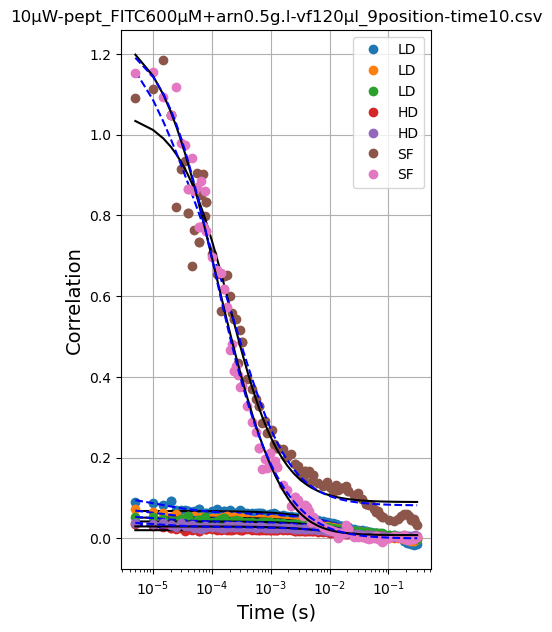

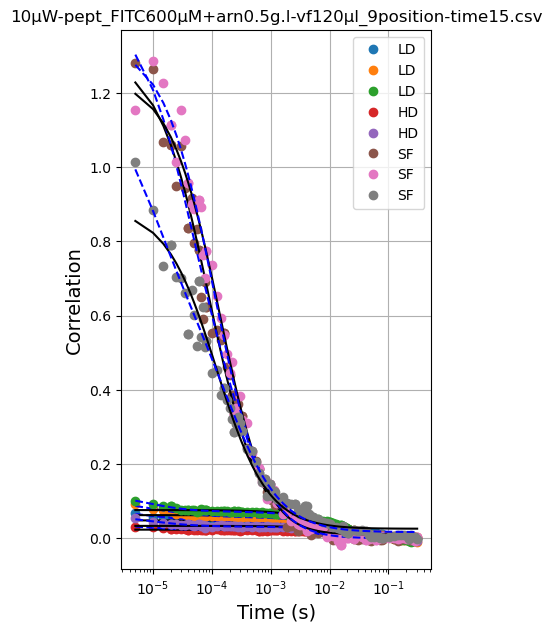

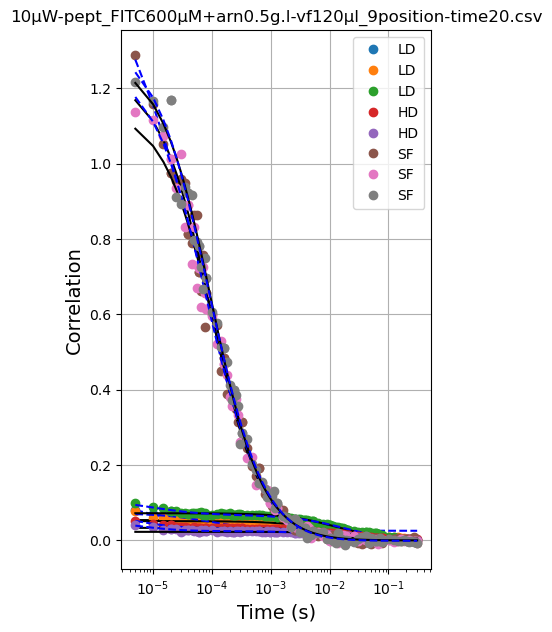

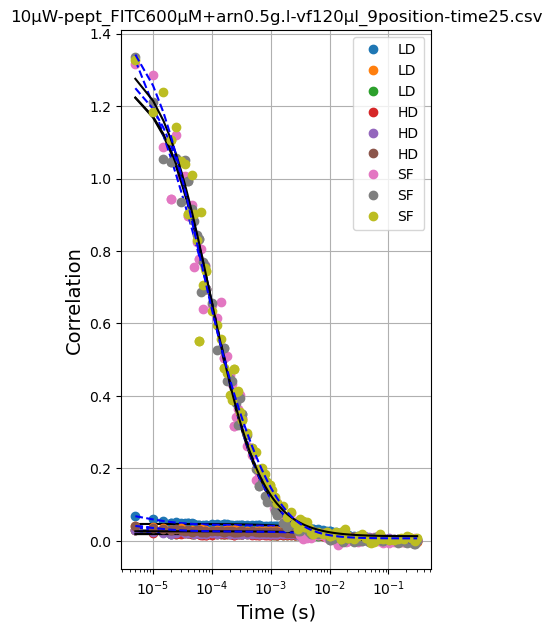

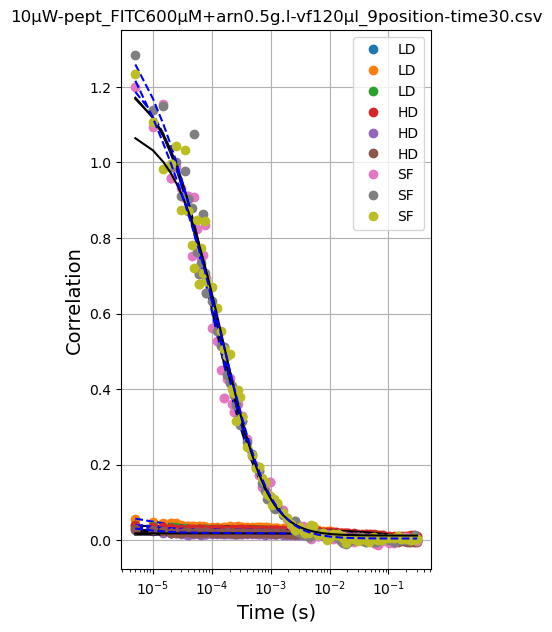

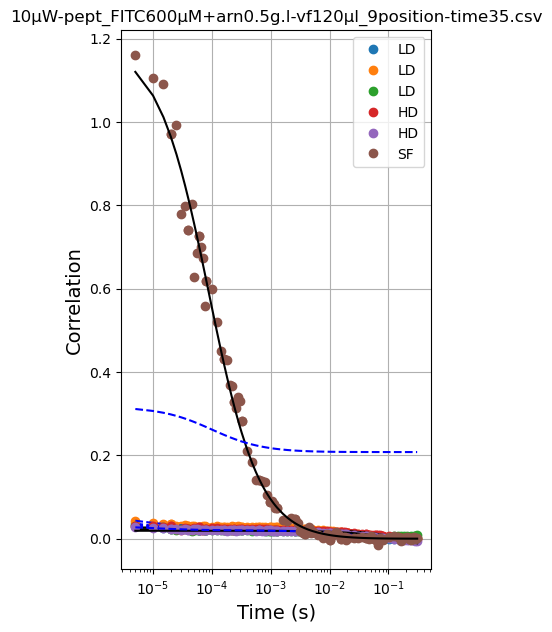

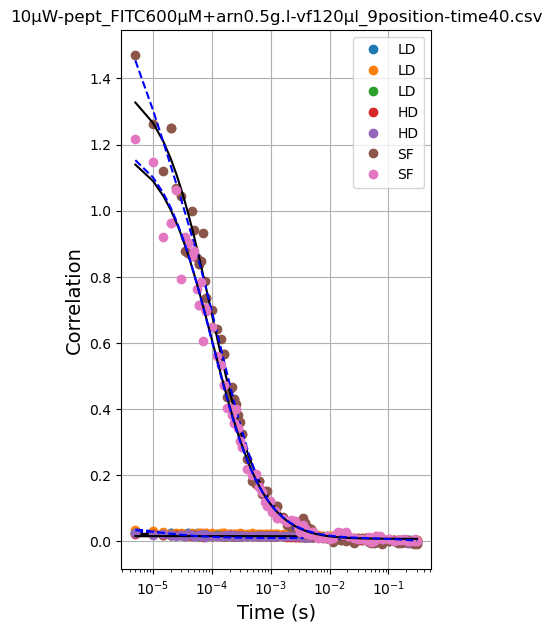

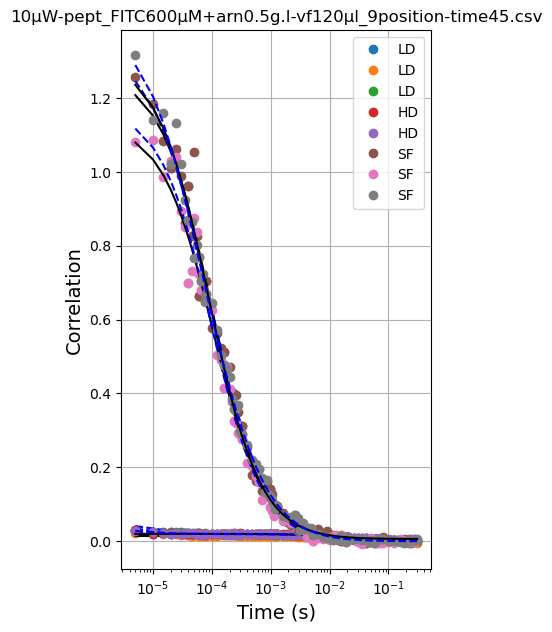

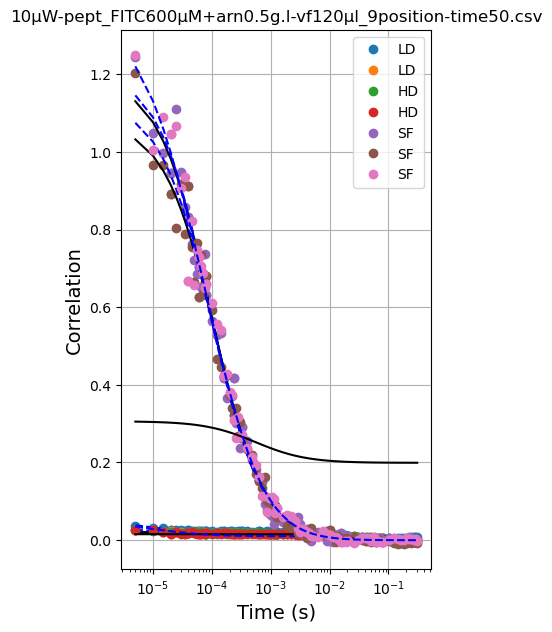

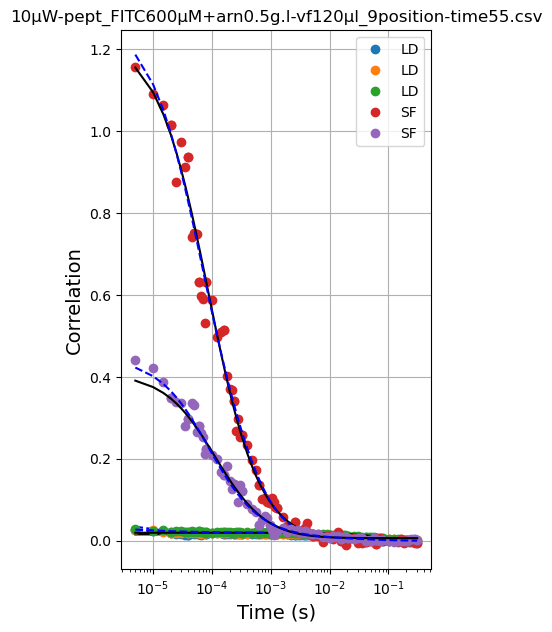

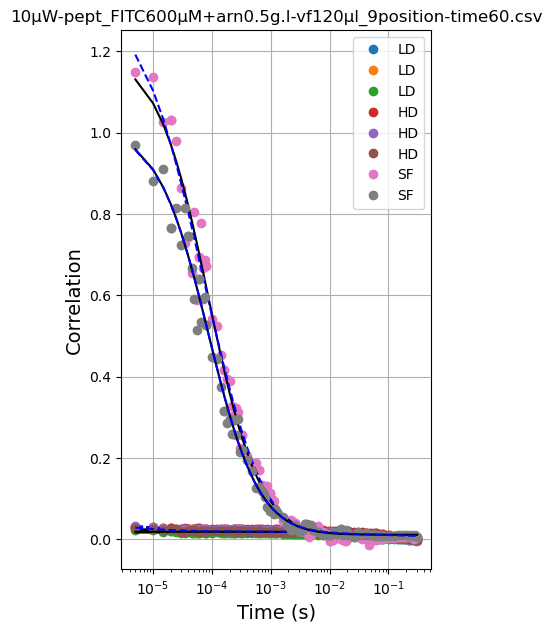

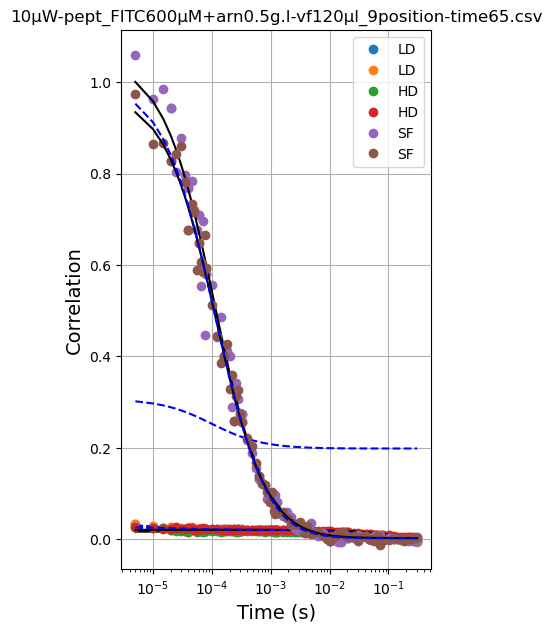

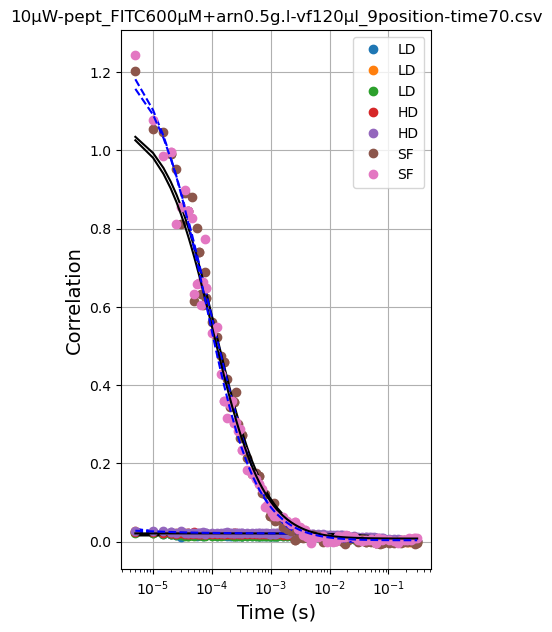

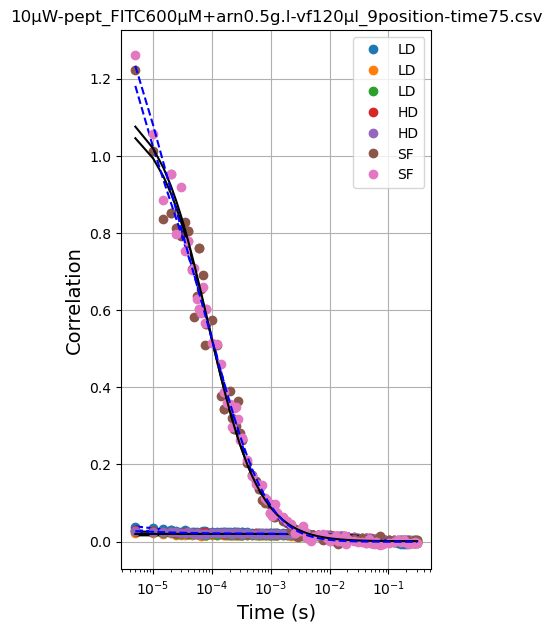

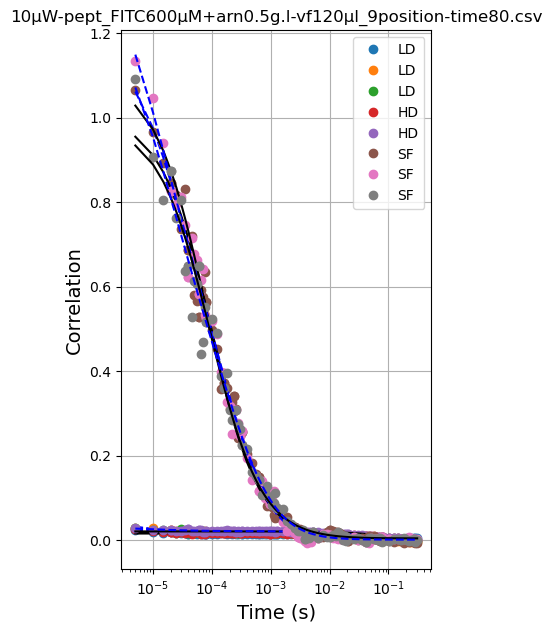

In [12]:
files.sort()

dates=[]
names=[]
nombres=[]
concentration=[]
power=[]
cps=[]
phase=[]
times=[]
pop=[]
tauds=[]
tauds1=[]
tauds2=[]
difcoefs1=[]
difcoefs2=[]
fraction=[]
chi2=[]
offset=[]
#position=[]

curated_data = pd.read_csv(Folder+date+'/Results/'+date+'_data.csv')

def concat(a,b):
    return int(f"{a}{b}")

i=0
for filename in files:
    indices = range(9*i,9*i+10-1)
    quality=curated_data.iloc[indices,:].reset_index()
    i=i+1

    print(filename)
      
    data=loadtxt(InputFolder+filename, delimiter=',', skiprows=13)
    title = filename
    
    
    #time = filename.split('.')[-2].split('-')[-1]
    
    t = [int(j) for j in filename.split('.')[-2].split('-')[-1] if j.isdigit()]
    if len(t)>1:
        time = concat(t[0],t[1])
    else:
        time = t
    print(time)  
   
    laser_power = filename.split('.')[0].split('-')[0]
    
    xdata = data[0,:]


    colors=[]
    pos=[]

    
    
    fig = plt.figure(figsize=(4, 7))
    gs = gridspec.GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(title)
    ax1.set_xlabel('Time (s)', fontsize=14)
    ax1.set_ylabel('Correlation', fontsize=14)
    ax1.set_xscale('log')
    ax1.grid(True)

    for k in range(1,10):
        if quality['Quality'][k-1]=='bad':
            pass
        else:
            pos.append(quality['Phase'][k-1])
            ydata = data[(2*k+1),:] 
            
            
            if printres==1:
                print('Nb of species = ',n)
                print(' ')
                   
                
            ax1.plot(xdata, ydata,  marker='o', linestyle='None',label=quality['Phase'][k-1])
            
            for n in range (1,nb+1):
                nb_species=n
                if nb_species==1:
                    func=func1

                elif nb_species==2:
                    func=func2


                params = Parameters()

                if Nfix == 0:
                    params.add('N', value=Ninit, min=Nmin, max=Nmax)
                else:
                    params.add('N', value=Ninit, vary=False)

                if tfix == 0:
                    params.add('t', value=tinit, min=tmin, max=tmax)
                else:
                    params.add('t', value=tinit, vary=False)
                
                if t1fix == 0:
                    params.add('t1', value=t1init, min=t1min, max=t1max)
                else:
                    params.add('t1', value=t1init, vary=False)

                if t2fix == 0:
                    params.add('t2', value=t2init, min=t2min, max=t2max)
                else:
                    params.add('t2', value=t2init, vary=False)

                if Rfix == 0:
                    params.add('R', value=Rinit, min=Rmin, max=Rmax)
                else:
                    params.add('R', value=Rinit, vary=False)

                if Offfix == 0:
                    params.add('Offset', value=Offinit, min=Offmin, max=Offmax)
                else:
                    params.add('Offset', value=Offinit, vary=False)

                if F1fix == 0:
                    params.add('F1', value=F1init, min=F1min, max=F1max)
                else:
                    params.add('F1', value=F1init, vary=False)


                    
                fitted_params = fit_FCS(func,xdata,ydata,params)

                N = fitted_params.params['N'].value
                R = fitted_params.params['R'].value   # R=z0/w0
                Offset = fitted_params.params['Offset'].value
                res = fitted_params.redchi
                
                #conc = (N*R)/(6.022e14*(pow(round(pi,2),3/2))*(pow(w0,3)))       # picoquant formula, concentration in nM
                conc = N/(0.6022*V)      # ISS formula, concentration in NM
                
                
                
                if nb_species==1:
                    g=g1
                    t = fitted_params.params['t'].value
                    t1=float('nan')
                    t2=float('nan')
                    D1 = round(w0*w0/(4*t), 2)
                    D2=float('nan')
                    F1=1
                    ax1.plot(xdata, g(xdata,fitted_params.params), 'k-')
                    
                elif nb_species==2:
                    g=g2
                    F1=fitted_params.params['F1'].value
                    t1 = fitted_params.params['t1'].value
                    t2 = fitted_params.params['t2'].value
                    D1 = round(w0*w0/(4*t1), 2)
                    D2 = round(w0*w0/(4*t2), 2)
                    ax1.plot(xdata, g(xdata,fitted_params.params), 'b--')

                if printres == 1:
                    print('\nTime = ', time, ' s')
                    print('N =', round(N, 2))
                    print('diffusion time =', round(t1*1000, 3), 'ms')
                    print('Z0/w0 = ', round(R, 1))
                    print('Diffusion coefficient =', D, 'µm²/s')
                    print('Offset = ', Offset)
                    print('Reduced chi² = ',res)

                
                plt.legend()
                plt.savefig(OutputFolder+date+'_'+filename+'_'+'.jpg')
                if plotcorr==0:
                    plt.close()

                # Creates the list of values for Numbers, Time, Diffusion  for 1 and 2 species
                dates.append(date)
                names.append(filename)
                nombres.append(round(N, 2))
                concentration.append(round(conc,2))
                power.append(laser_power)
                #cps.append(counts)
                phase.append(quality['Phase'][k-1])
                times.append(time)
                pop.append(nb_species)
                offset.append(Offset)
                tauds.append(round(t*1000, 3))
                tauds1.append(round(t1*1000, 3))
                tauds2.append(round(t2*1000, 3))
                difcoefs1.append(round(D1,3))
                difcoefs2.append(round(D2,3))
                fraction.append(round(F1,2))
                chi2.append(res)

print('Done !!')            
            
df = pd.DataFrame()

df['Dates']=dates
df['Filename']=names                                
df['Power']=power
#df['cps']=cps
df['Phase']=phase
df['Time']=times
df['Nb of species']=pop
df['Offset']=offset
df['Nombres']=nombres
df['Concentration (nM)']=concentration
df['tauds']=tauds
df['tauds1']=tauds1
df['tauds2']=tauds2
df['D1']=difcoefs1
df['D2']=difcoefs2
df['F1']=fraction
df['chi2']=chi2

df.to_csv(OutputFolder+'results.csv')

In [13]:
df

,Dates,Filename,Power,Phase,Time,Nb of species,Offset,Nombres,Concentration (nM),tauds,tauds1,tauds2,D1,D2,F1,chi2
0,240112,10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9positio...,10µW,LD,10,1,-0.008007,13.17,28.91,16.810,NaN,NaN,1.69,NaN,1.00,0.000043
1,240112,10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9positio...,10µW,LD,10,2,-0.013694,8.19,17.97,16.810,0.012,26.995,2312.16,1.05,0.39,0.000018
2,240112,10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9positio...,10µW,LD,10,1,-0.004369,17.89,39.28,15.832,NaN,NaN,1.79,NaN,1.00,0.000015
3,240112,10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9positio...,10µW,LD,10,2,-0.007295,11.51,25.27,15.832,0.010,21.556,2839.22,1.32,0.37,0.000005
4,240112,10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9positio...,10µW,LD,10,1,0.000090,23.86,52.39,21.641,NaN,NaN,1.31,NaN,1.00,0.000018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,240112,10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9positio...,10µW,SF,80,2,0.001875,0.85,1.87,0.100,0.039,0.389,720.97,73.04,0.53,0.000572
216,240112,10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9positio...,10µW,SF,80,1,0.000154,0.92,2.01,0.081,NaN,NaN,351.87,NaN,1.00,0.000846
217,240112,10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9positio...,10µW,SF,80,2,0.000226,0.72,1.58,0.081,0.013,0.213,2257.11,133.52,0.49,0.000479
218,240112,10µW-pept_FITC600µM+arn0.5g.l-vf120µl_9positio...,10µW,SF,80,1,0.003804,1.02,2.24,0.093,NaN,NaN,304.62,NaN,1.00,0.001268


In [14]:
df = pd.DataFrame()

time=[]
for i in range(len(times)):
    time.append(int(times[i].replace('time','')))
    
    
df = pd.DataFrame()

df['Dates']=dates
df['Filename']=names                                
df['Power']=power
#df['cps']=cps
df['Phase']=phase
df['Time']=times
df['Nb of species']=pop
df['Offset']=offset
df['Nombres']=nombres
df['Concentration (nM)']=concentration
df['tauds']=tauds
df['tauds1']=tauds1
df['tauds2']=tauds2
df['D1']=difcoefs1
df['D2']=difcoefs2
df['F1']=fraction
df['chi2']=chi2

df.to_csv(OutputFolder+'results.csv')


AttributeError: 'int' object has no attribute 'replace'

In [ ]:
df


---

## Plot parameters <a class='anchor' id='plot'></a>


For now, we will only fit 1 component fittings.





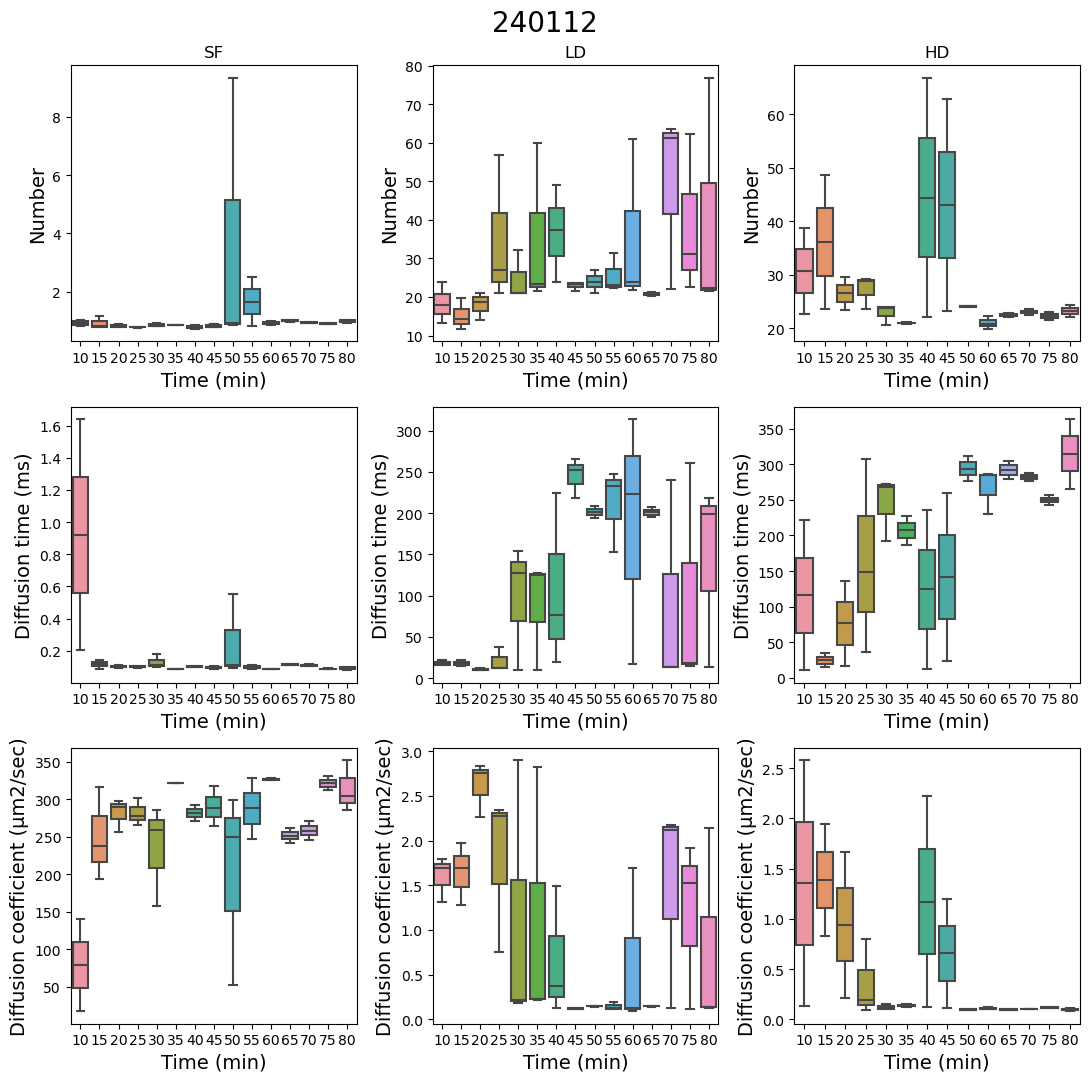

In [25]:
data = pd.read_csv(OutputFolder+'results.csv')

data1=data[data['Nb of species']==1]
data2=data[data['Nb of species']==2]

phases = ['SF','LD','HD']

fig,axs = plt.subplots(3,3,figsize=(11,11), tight_layout=True)
fig.suptitle(date, fontsize=20)
for i in range(3):
    p=phases[i]
    datap=data1[data1['Phase']==p]
    sns.boxplot(x=datap['Time'],y=datap['Nombres'],ax=axs[0,i])
    axs[0,i].set_title(p)
    #axs[0,i].set_yscale('log')
    axs[0,i].set_ylabel('Number', fontsize=14)
    #axs[0,i].set_ylim([0,100])
    axs[0,i].set_xlabel('Time (min)', fontsize=14)
    sns.boxplot(x=datap['Time'],y=datap['tauds'],ax=axs[1,i])
    #axs[1,i].set_yscale('log')
    axs[1,i].set_ylabel('Diffusion time (ms)', fontsize=14)
    axs[1,i].set_xlabel('Time (min)', fontsize=14)
    sns.boxplot(x=datap['Time'],y=datap['D1'], ax=axs[2,i])
    #axs[2,i].set_yscale('log')
    axs[2,i].set_ylabel('Diffusion coefficient (µm2/sec)', fontsize=14)
    axs[2,i].set_xlabel('Time (min)', fontsize=14)


#axs[0].legend([],frameon=False)
#axs[1].legend([],frameon=False)
#axs[2].legend([],frameon=False)

plt.savefig(OutputFolder+date+'_compiled_plots_1comp.jpg')


/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_38457/2127973529.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_data1 = data1.groupby(['Phase', 'Time']).mean().reset_index()
/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_38457/2127973529.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_data1 = data1.groupby(['Phase', 'Time']).std().reset_index()


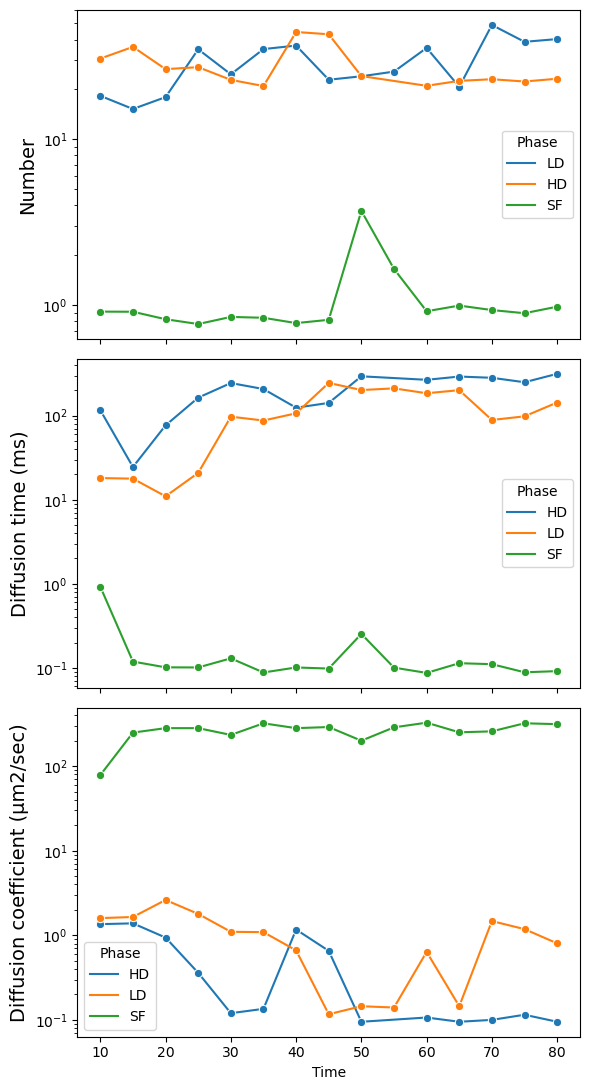

In [16]:
mean_data1 = data1.groupby(['Phase', 'Time']).mean().reset_index()
std_data1 = data1.groupby(['Phase', 'Time']).std().reset_index()
merged_data1 = pd.merge(mean_data1,std_data1,on=['Time', 'Phase'], 
                        suffixes=('_mean', '_std'))

labels=['LD','HD','SF']
palette=['b','g','r']

fig, axs = plt.subplots(3,1,figsize=(6,11), sharex=True,tight_layout=True)
sns.lineplot(data=merged_data1, x='Time', y='Nombres_mean', hue='Phase', 
             hue_order=labels, marker='o', ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_ylabel('Number', fontsize=14)
plt.legend([],[],frameon=False)
sns.lineplot(data=merged_data1, x='Time', y='tauds_mean', hue='Phase', 
             marker='o',ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_ylabel('Diffusion time (ms)', fontsize=14)
plt.legend([],[],frameon=False)
sns.lineplot(data=merged_data1, x='Time', y='D1_mean', hue='Phase', 
             marker='o',ax=axs[2])
axs[2].set_yscale('log')
axs[2].set_ylabel('Diffusion coefficient (µm2/sec)', fontsize=14)

'''
# Add error bars
for phase in merged_data1['Phase'].unique():
    phase_data = merged_data1[merged_data1['Phase'] == phase]
    axs[0].errorbar(phase_data['Time'], phase_data['Nombres_mean'],
                 yerr=phase_data['Nombres_std'], fmt='x',ecolor='k')
    axs[1].errorbar(phase_data['Time'], phase_data['tauds_mean'],
                 yerr=phase_data['tauds_std'], fmt='x',ecolor='k')
    axs[2].errorbar(phase_data['Time'], phase_data['D1_mean'],
                 yerr=phase_data['D1_std'], fmt='x',ecolor='k')
                 
                 '''
    
plt.savefig(OutputFolder+'kinetic_1component.jpg')

In [ ]:
mean_data2 = data2.groupby(['Phase', 'Time']).mean().reset_index()
std_data2 = data2.groupby(['Phase', 'Time']).std().reset_index()
merged_data2 = pd.merge(mean_data2,std_data2,on=['Time', 'Phase'], 
                        suffixes=('_mean', '_std'))

labels=['LD','HD','SF']
palette=['b','g','r']

fig, axs = plt.subplots(6,1,figsize=(6,14), sharex=True,tight_layout=True)
sns.lineplot(data=merged_data2, x='Time', y='Nombres_mean', hue='Phase', 
             hue_order=labels, marker='o', ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_ylabel('Number', fontsize=12)
#plt.legend([],[],frameon=False)

sns.lineplot(data=merged_data2, x='Time', y='F1_mean', hue='Phase', 
             hue_order=labels, marker='o', ax=axs[1])
axs[1].set_ylabel('Fraction 1', fontsize=12)
#plt.legend([],[],frameon=False)

sns.lineplot(data=merged_data2, x='Time', y='tauds1_mean', hue='Phase', 
             marker='o',ax=axs[2])
axs[2].set_yscale('log')
axs[2].set_ylabel('Diffusion time #1 (ms)', fontsize=12)
#plt.legend([],[],frameon=False)

sns.lineplot(data=merged_data2, x='Time', y='tauds2_mean', hue='Phase', 
             marker='o',ax=axs[3])
axs[3].set_yscale('log')
axs[3].set_ylabel('Diffusion time #2 (ms)', fontsize=12)
#plt.legend([],[],frameon=False)

sns.lineplot(data=merged_data2, x='Time', y='D1_mean', hue='Phase', 
             marker='o',ax=axs[4])
axs[4].set_yscale('log')
axs[4].set_ylabel('Diffusion coefficient #1 \n(µm2/sec)', fontsize=12)
#plt.legend([],[],frameon=False)

sns.lineplot(data=merged_data2, x='Time', y='D2_mean', hue='Phase', 
             marker='o',ax=axs[5])
axs[5].set_yscale('log')
axs[5].set_ylabel('Diffusion coefficient #1 \n(µm2/sec)', fontsize=12)



# Add error bars
for phase in merged_data2['Phase'].unique():
    phase_data = merged_data2[merged_data2['Phase'] == phase]
    axs[0].errorbar(phase_data['Time'], phase_data['Nombres_mean'],
                 yerr=phase_data['Nombres_std'],fmt='x',ecolor='k')
    axs[1].errorbar(phase_data['Time'], phase_data['F1_mean'],
                 yerr=phase_data['F1_std'],fmt='x',ecolor='k')
    axs[2].errorbar(phase_data['Time'], phase_data['tauds1_mean'],
                 yerr=phase_data['tauds1_std'], fmt='x',ecolor='k')
    axs[3].errorbar(phase_data['Time'], phase_data['tauds2_mean'],
                 yerr=phase_data['tauds2_std'], fmt='x',ecolor='k')
    axs[4].errorbar(phase_data['Time'], phase_data['D1_mean'],
                 yerr=phase_data['D1_std'], fmt='x',ecolor='k')
    axs[5].errorbar(phase_data['Time'], phase_data['D2_mean'],
                 yerr=phase_data['D2_std'], fmt='x',ecolor='k')
    
    
plt.savefig(OutputFolder+'kinetic_2component.jpg')    

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(11,4),sharey=True)
sns.boxplot(x=data1['Phase'],y=data1['D1'],ax=axs[0])
axs[0].set_yscale('log')
sns.scatterplot(x=data2['F1'],y=data2['D1'],hue=data2['Phase'], ax=axs[1])
sns.scatterplot(x=1-data2['F1'],y=data2['D2'],hue=data2['Phase'], ax=axs[2])

In [ ]:
#sns.swarmplot(x=data['Phase'],y=data['F1'],hue=data['Time'],ax=ax,color='k')

In [ ]:
fig,axs = plt.subplots()
sns.boxplot(x=df['Phase'],y=df['chi2'],hue=df['Nb of species'],ax=axs)

axs.set_yscale('log')


In [ ]:


df_res=df[df['chi2']<1e-5]
df_res

df_qual=df_res[np.abs(df_res['Offset'])<0.01]

In [ ]:
# PLOT results for 1 species

data=df


if nb_species == 1:

    fig, axs = plt.subplots(2,4, figsize=(11, 8), tight_layout=True, sharex=True)

    # Plot figure 1 with positions and numbers
    sns.boxplot(x=data['Phase'], y=data['Nombres'], hue=data['Power'],ax=axs[0,0])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[0,0].set_ylim(0, max(log(nombres))*1.1)
    axs[0,0].set_yscale('log')
    #axs[0,0].set_xlabel('Positions', fontsize=10)
    axs[0,0].set_ylabel('Number', fontsize=10)
    
    
    sns.boxplot(x=data['Phase'], y=data['Nombres'], hue=data['Time'], ax=axs[1,0])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[1,0].set_ylim(0, max(nombres)*1.1)
    axs[1,0].set_yscale('log')
    #axs[1,0].set_xlabel('Positions', fontsize=10)
    axs[1,0].set_ylabel('Number', fontsize=10)
    axs[1,0].legend('off')

    # Plot figure 2 with diffusion coefficients

    sns.boxplot(x=data['Phase'], y=data['difcoefs'], hue=data['Power'], ax=axs[0,1])
    #axs[0,1].set_ylim(0, max(difcoefs)*1.1)
    #axs[0,1].set_xlabel('Positions', fontsize=10)
    axs[0,1].set_yscale('log')
    axs[0,1].set_ylabel('Diffusion coefficient (µm²/s)', fontsize=10)
    
    sns.boxplot(x=data['Phase'], y=data['difcoefs'], hue=data['Time'], ax=axs[1,1])
    #axs[1,1].set_ylim(0, max(difcoefs)*1.1)
    #axs[1,1].set_xlabel('Positions', fontsize=10)
    axs[1,1].set_yscale('log')
    axs[1,1].set_ylabel('Diffusion coefficient (µm²/s)', fontsize=10)

    # Plot figure 3 with times and CPS

    sns.boxplot(x=data['Phase'], y=data['cps'], hue=data['Power'], ax=axs[0,2])
    #axs[0,2].set_ylim(0, max(cps)*1.1)
    axs[0,2].set_yscale('log')
    #axs[0,2].set_xlabel('Positions', fontsize=10)
    axs[0,2].set_ylabel('Count (cps)', fontsize=10)
    
    sns.boxplot(x=data['Phase'], y=data['cps'], hue=data['Time'], ax=axs[1,2])
    #axs[1,2].set_ylim(0, max(cps)*1.1)
    axs[1,2].set_yscale('log')
    #axs[1,2].set_xlabel('Positions', fontsize=10)
    axs[1,2].set_ylabel('Count (cps)', fontsize=10)

    sns.boxplot(x=data['Phase'], y=data['chi2'], hue=data['Power'],ax=axs[0,3])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[0,0].set_ylim(0, max(log(nombres))*1.1)
    axs[0,3].set_yscale('log')
    #axs[0,0].set_xlabel('Positions', fontsize=10)
    axs[0,3].set_ylabel('reduced chi2', fontsize=10)
    
    
    sns.boxplot(x=data['Phase'], y=data['chi2'], hue=data['Time'], ax=axs[1,3])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[1,0].set_ylim(0, max(nombres)*1.1)
    axs[1,3].set_yscale('log')
    #axs[1,0].set_xlabel('Positions', fontsize=10)
    axs[1,3].set_ylabel('reduced chi2', fontsize=10)
    axs[1,3].legend('off')
    
plt.savefig(OutputFolder+'results_chi2_e-5_offset_0.01.jpg')
   

In [ ]:
data=df

if nb_species == 1:

    fig, axs = plt.subplots(1,4, figsize=(11, 4), tight_layout=True, sharex=True)

    # Plot figure 1 with positions and numbers
    sns.boxplot(x=data['Phase'], y=data['Offset'],ax=axs[0])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[0,0].set_ylim(0, max(log(nombres))*1.1)
    axs[0].set_yscale('log')
    #axs[0,0].set_xlabel('Positions', fontsize=10)
    axs[0].set_ylabel('Number', fontsize=10)
    
    


    # Plot figure 2 with diffusion coefficients

    sns.boxplot(x=data['Phase'], y=data['difcoefs'], ax=axs[1])
    #axs[0,1].set_ylim(0, max(difcoefs)*1.1)
    #axs[0,1].set_xlabel('Positions', fontsize=10)
    axs[1].set_yscale('log')
    axs[1].set_ylabel('Diffusion coefficient (µm²/s)', fontsize=10)
    

    # Plot figure 3 with times and CPS

    sns.boxplot(x=data['Phase'], y=data['cps'], ax=axs[2])
    #axs[0,2].set_ylim(0, max(cps)*1.1)
    axs[2].set_yscale('log')
    #axs[0,2].set_xlabel('Positions', fontsize=10)
    axs[2].set_ylabel('Count (cps)', fontsize=10)

    

    sns.boxplot(x=data['Phase'], y=data['chi2'], ax=axs[3])
    #sns.swarmplot(x=df['Phase'], y=df['Nombres'], hue=df['Power'], ax=axs[0,0])
    #axs[0,0].set_ylim(0, max(log(nombres))*1.1)
    axs[3].set_yscale('log')
    #axs[0,0].set_xlabel('Positions', fontsize=10)
    axs[3].set_ylabel('reduced chi2', fontsize=10)
      
plt.savefig(OutputFolder+'mixed_results_unflitered.jpg')
   